# Kernel Principal Components Analysis: Iris Data Set

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

## Load and normalize the data

In [2]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_scaled = (X_train - X_train_mean) / X_train_std
X_test_scaled = (X_test - X_train_mean) / X_train_std

N_train = X_train_scaled.shape[0]
N_test = X_test_scaled.shape[0]

## Perform Kernel PCA

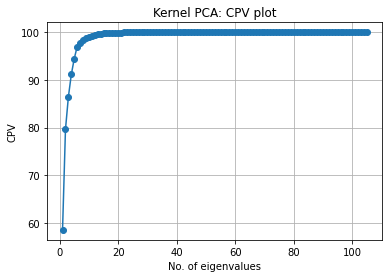

In [3]:
# Define the kernel function:
def kernel_func(x1, x2, kw):
    return np.exp(-pairwise_distances(x1, x2, metric='sqeuclidean') / kw ** 2)

# Compute the kernel covariance matrix
kw = 4
K_train = kernel_func(X_train_scaled, X_train_scaled, kw)

# Center the kernel matrix
U_train = np.ones((N_train, N_train)) / N_train
K_train_cent = K_train - U_train @ K_train - K_train @ U_train + U_train @ K_train @ U_train  

# Perform eigenvalue decomposition
eigvals, eigvecs = np.linalg.eig(K_train_cent / N_train)

# Ensure the eigenvalues are sorted in decreasing order
ind = (-eigvals).argsort()
eigvals = eigvals[ind]
eigvecs = eigvecs[:,ind]

# Plot the CPV
cpv = np.cumsum(eigvals) / np.sum(eigvals) * 100
plt.plot(range(1,len(eigvals)+1),cpv,'o-')
plt.title('Kernel PCA: CPV plot')
plt.xlabel('No. of eigenvalues')
plt.ylabel('CPV')
plt.grid()
plt.show()

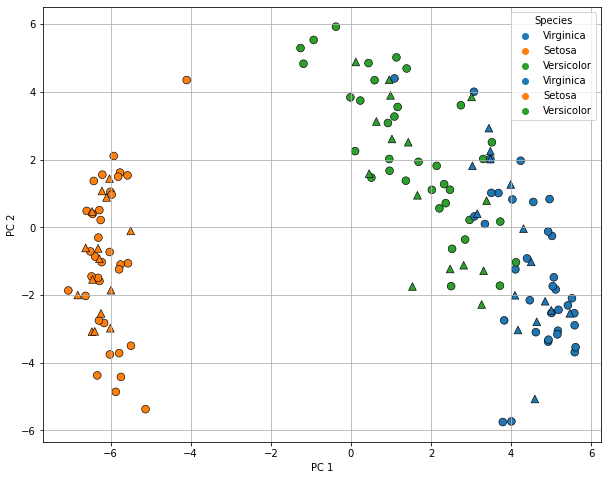

In [4]:
# Project only using the first 2 principal components (eigenvectors)
P = eigvecs[:,:2] @ np.diag(eigvals[:2] ** -0.5)
train_scores = K_train_cent @ P

K_test = kernel_func(X_test_scaled, X_train_scaled, kw)
U_test = np.ones((N_test, N_train)) / N_train
K_test_cent = K_test - U_test @ K_train - K_test @ U_train + U_test @ K_train @ U_train
test_scores = K_test_cent @ P

# Visualize the Kernel PC scores
kpca_train = pd.DataFrame(np.hstack((train_scores, y_train.reshape(-1,1))), 
                         columns=['PC 1', 'PC 2', 'Species'])
kpca_test = pd.DataFrame(np.hstack((test_scores, y_test.reshape(-1,1))), 
                         columns=['PC 1', 'PC 2', 'Species'])
target_names = {0:'Setosa', 1:'Versicolor', 2:'Virginica'}
kpca_train["Species"] = kpca_train["Species"].map(target_names)
kpca_test["Species"] = kpca_test["Species"].map(target_names)

plt.figure(figsize=(10,8))
sns.scatterplot(data=kpca_train, x="PC 1", y="PC 2", s=60, edgecolor='k', marker='o', hue='Species')
sns.scatterplot(data=kpca_test, x="PC 1", y="PC 2", s=60, edgecolor='k', marker='^', hue='Species')
plt.grid()
plt.show()